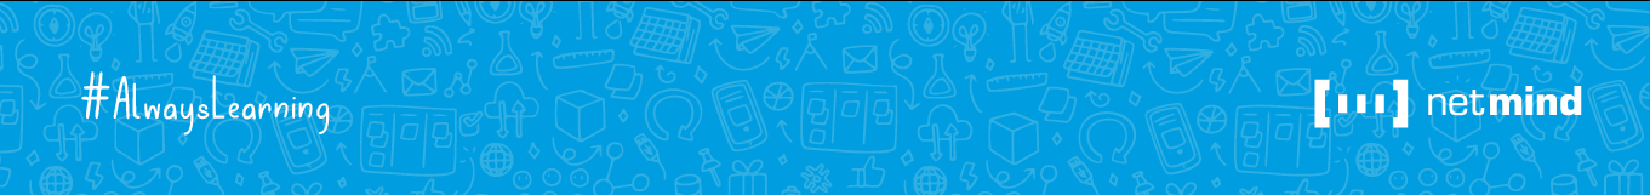
# **Diseño e Implementación de Pipelines en Azure Machine Learning**



## **Pipelines en Azure ML**  

Un pipeline en Azure ML es una colección de pasos interconectados que definen el flujo de trabajo de un modelo de machine learning. Cada paso puede ejecutarse en diferentes destinos de proceso y reutilizarse en múltiples proyectos.

- [Azure ML Pipelines Documentation](https://learn.microsoft.com/en-us/azure/machine-learning/concept-ml-pipelines)

### Beneficios de los Pipelines
- **Automatización:** Reducen la intervención manual en procesos repetitivos.
- **Reproducibilidad:** Garantizan resultados consistentes al ejecutar el mismo flujo de trabajo.
- **Escalabilidad:** Permiten manejar grandes volúmenes de datos y modelos complejos.

### Componentes de un Pipeline
- **Módulos:** Bloques reutilizables que realizan tareas específicas, como limpieza de datos o entrenamiento de modelos.
- **Scripts:** Código personalizado para procesamiento o entrenamiento.
- **Datos:** Conjuntos de datos utilizados en cada paso.
- **Compute Targets:** Recursos computacionales donde se ejecutan los pasos.


## **Diseño de Pipelines**  

### **Definición de Pasos**
Cada paso en un pipeline debe estar claramente definido y debe cumplir con un propósito específico.

#### Tipos de Pasos Comunes
- **Ingesta de Datos:** Descargar datos desde Blob Storage, SQL Database o APIs RESTful.
- **Preprocesamiento:** Limpieza, normalización y transformación de datos.
- **Entrenamiento:** Entrenar modelos utilizando frameworks como Scikit-learn, TensorFlow o PyTorch.
- **Evaluación:** Validar el modelo utilizando métricas clave.
- **Despliegue:** Exponer el modelo como un servicio web.

#### Ejemplo: Definición de Pasos


In [ ]:
from azureml.pipeline.steps import PythonScriptStep

# Paso de Ingesta
paso_ingesta = PythonScriptStep(
    script_name="ingesta.py",
    compute_target="mi-cluster",
    source_directory="./scripts"
)

# Paso de Preprocesamiento
paso_preprocesamiento = PythonScriptStep(
    script_name="preprocesamiento.py",
    compute_target="mi-cluster",
    source_directory="./scripts"
)


### **Conexión de Pasos**
Los pasos de un pipeline deben conectarse de manera lógica, asegurando que las salidas de un paso sean las entradas del siguiente.

#### Dependencias entre Pasos
- Un paso puede depender de la salida de otro paso.
- Las dependencias se definen utilizando el parámetro `depends_on`.

#### Ejemplo: Conexión de Pasos


In [ ]:
from azureml.pipeline.core import Pipeline

pipeline = Pipeline(
    workspace=ws,
    steps=[paso_ingesta, paso_preprocesamiento]
)
pipeline.validate()

## **Implementación de Pipelines**

### Configuración de Compute Targets
Los compute targets son recursos computacionales donde se ejecutan los pasos del pipeline.

#### Tipos de Compute Targets
- **Máquinas Virtuales:** Ideal para pruebas rápidas.
- **Clústeres de GPU:** Para entrenamiento intensivo.
- **Azure Kubernetes Service (AKS):** Para despliegue en producción.

#### Ejemplo: Creación de un Clúster de Proceso

In [ ]:
from azureml.core.compute import AmlCompute

compute_config = AmlCompute.provisioning_configuration(
    vm_size="STANDARD_D2_V2",
    max_nodes=4
)

compute_target = AmlCompute.create(ws, "mi-cluster", compute_config)
compute_target.wait_for_completion(show_output=True)

### Ejecución de Pipelines
Una vez configurado, el pipeline puede enviarse para su ejecución.
- Los pipelines se ejecutan como experimentos en Azure ML.

#### Ejemplo: Envío de un Pipeline

In [ ]:
from azureml.core import Experiment

experimento = Experiment(workspace=ws, name="mi-experimento-pipeline")
ejecucion = experimento.submit(pipeline)
ejecucion.wait_for_completion(show_output=True)

## **Monitoreo y Optimización de Pipelines**  

Azure ML proporciona herramientas para monitorear el rendimiento de los pipelines.

#### Métricas Clave
- Tiempo de ejecución de cada paso.
- Uso de recursos computacionales.

#### Ejemplo: Monitoreo de Pipelines


In [ ]:
print(f"Estado de la ejecucion: {ejecucion.get_status()}")
print(f"Duración: {ejecucion.get_duration()}")

### Optimización de Pipelines
Optimiza tus pipelines para mejorar el rendimiento y reducir costos.

#### Estrategias de Optimización
- **Paralelización:** Ejecuta pasos independientes en paralelo.
- **Reutilización:** Almacena y reutiliza artefactos generados por pasos previos.

## **Implementación usnado `@pipeline`**

En Azure ML se puede definir pipelines de manera programática utilizando el decorador `@pipeline`. Este enfoque simplifica la creación de pipelines al permitirte encapsular lógica compleja en una función decorada, lo que facilita la reutilización y organización del código.

### Ventajas de Usar @pipeline
- *Modularidad*: Facilita la creación de pipelines modulares y reutilizables.
- *Declarativo*: Define flujos de trabajo de manera clara y estructurada.
- *Reutilización*: Los componentes pueden reutilizarse en diferentes pipelines.
- *Escalabilidad*: Permite gestionar pipelines complejos con múltiples pasos de manera eficiente.

### Definir los Componentes
Los componentes son bloques reutilizables que representan tareas específicas dentro del pipeline. Pueden ser scripts Python, comandos o componentes registrados previamente.

In [ ]:
# Componente para preprocesar datos
preprocess_component = command(
    code="./src",  # Carpeta que contiene el script
    command="python preprocess.py --input_data ${{inputs.raw_data}} --output_data ${{outputs.processed_data}}",
    inputs={
        "raw_data": Input(type="uri_folder"),
    },
    outputs={
        "processed_data": Output(type="uri_folder"),
    },
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
)

# Componente para entrenar un modelo
train_component = command(
    code="./src",
    command="python train.py --training_data ${{inputs.training_data}} --model_output ${{outputs.model}}",
    inputs={
        "training_data": Input(type="uri_folder"),
    },
    outputs={
        "model": Output(type="uri_folder"),
    },
    environment="AzureML-tensorflow-2.7-ubuntu18.04-py37-cpu@latest",
)

### Definir el Pipeline con @pipeline
Usa el decorador @pipeline para definir el flujo de trabajo del pipeline. Dentro de la función decorada, conecta los componentes mediante sus entradas y salidas.

In [ ]:
@pipeline()
def mi_pipeline(raw_data):
    # Paso 1: Preprocesamiento de datos
    preprocessed_data = preprocess_component(raw_data=raw_data)

    # Paso 2: Entrenamiento del modelo
    trained_model = train_component(training_data=preprocessed_data.outputs.processed_data)

    # Retornar las salidas del pipeline
    return {
        "modelo_entrenado": trained_model.outputs.model,
    }

### Crear y Enviar el Pipeline

In [ ]:
# Crear una instancia del pipeline
pipeline_job = mi_pipeline(
    raw_data=Input(type="uri_folder", path="azureml://datastores/my_datastore/paths/raw_data")
)

# Enviar el pipeline para ejecución
returned_job = ml_client.jobs.create_or_update(pipeline_job)
print(f"Pipeline enviado: {returned_job.name}")

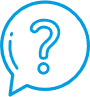
## **¿Preguntas?**